<a href="https://colab.research.google.com/github/PrajwalRaj21/Company-Valuation-and-Analysis/blob/main/Ranking_Companies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Yahoo Finance API for live data



In [1]:
!pip install yfinance

Analyzing five different companies because they have high market cap and span multiple sectors.

In [6]:
import yfinance as yf
import pandas as pd

companies = ['AAPL', "GOOGL", "AMZN", "MSFT", "TSLA"]

all_data = []

for ticker in companies:
  company = yf.Ticker(ticker)
  data = {
        "Company": ticker,
        "Market Cap": company.info.get("marketCap"),
        "P/E Ratio": company.info.get("trailingPE"),
        "Revenue": company.info.get("totalRevenue"),
        "Net Income": company.info.get("netIncomeToCommon"),
        "Total Debt": company.info.get("totalDebt"),
        "EBITDA": company.info.get("ebitda"),
        "Dividend Yield": company.info.get("dividendYield"),
    }

  all_data.append(data)


financial_data = pd.DataFrame(all_data)
financial_data.to_csv('financial_data.csv', index = False)



In [8]:
financial_data = pd.read_csv('financial_data.csv')

financial_data.head()

,Company,Market Cap,P/E Ratio,Revenue,Net Income,Total Debt,EBITDA,Dividend Yield
0,AAPL,3812204478464,41.480263,391034994688,93736001536,119058997248,134660997120,0.0039
1,GOOGL,2347987369984,25.363396,339859013632,94268997632,29289000960,123469996032,0.0042
2,AMZN,2326969712640,47.286327,620127977472,49868001280,158534991872,111583002624,NaN
3,MSFT,3158559948800,35.109917,254189993984,90511998976,96838000640,136551997440,0.0077
4,TSLA,1339911176192,113.735695,97150001152,12743000064,12782999552,13244000256,NaN


In [10]:
numeric_data = financial_data.select_dtypes(include = ['number'])

financial_data.fillna(numeric_data.mean(), inplace=True)

financial_data['Debt-to-Equity Ratio'] = financial_data['Total Debt']/ financial_data ['Market Cap']
financial_data["Revenue Growth Rate"] = financial_data["Revenue"].pct_change()

financial_data.dropna(inplace=True)

financial_data


,Company,Market Cap,P/E Ratio,Revenue,Net Income,Total Debt,EBITDA,Dividend Yield,Debt-to-Equity Ratio,Revenue Growth Rate
1,GOOGL,2347987369984,25.363396,339859013632,94268997632,29289000960,123469996032,0.004200,0.012474,-0.130873
2,AMZN,2326969712640,47.286327,620127977472,49868001280,158534991872,111583002624,0.005267,0.068129,0.824662
3,MSFT,3158559948800,35.109917,254189993984,90511998976,96838000640,136551997440,0.007700,0.030659,-0.590101
4,TSLA,1339911176192,113.735695,97150001152,12743000064,12782999552,13244000256,0.005267,0.009540,-0.617806


Performing EDA

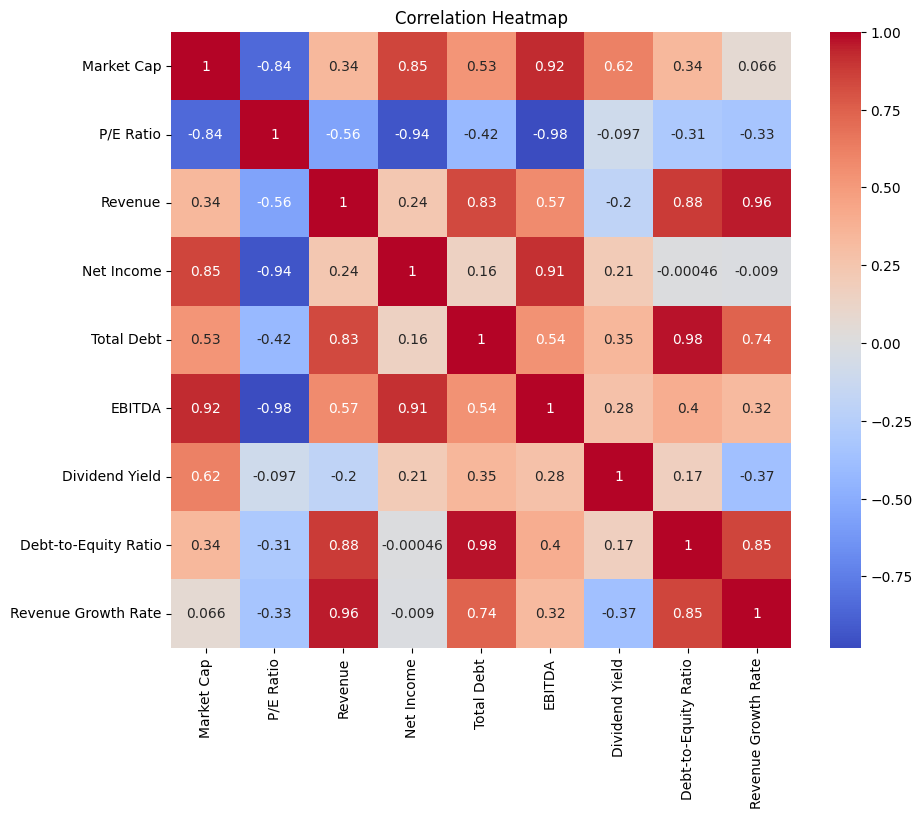

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_data = financial_data.select_dtypes(include=['number'])

plt.figure(figsize = (10,8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()





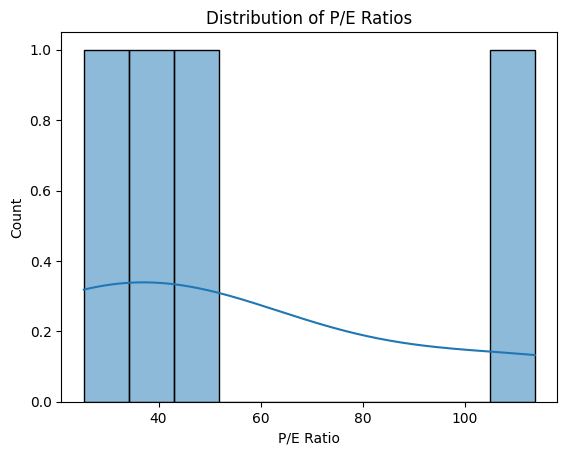

In [16]:
#P/E ratios

sns.histplot(financial_data['P/E Ratio'], kde = True, bins = 10)
plt.title('Distribution of P/E Ratios')
plt.show()



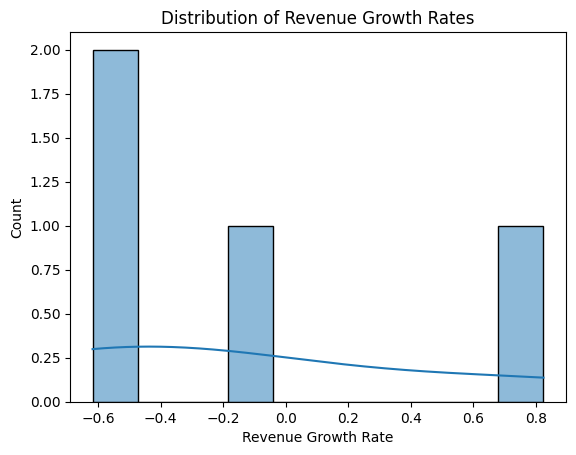

In [17]:
#Revenue Growth Rate

sns.histplot(financial_data['Revenue Growth Rate'], kde = True, bins = 10)
plt.title('Distribution of Revenue Growth Rates')
plt.show()

Predicting the Market Cap using Random Forest machine  learning model

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = financial_data[["P/E Ratio", "Revenue", "Net Income", "Debt-to-Equity Ratio"]]
y = financial_data["Market Cap"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


print("RMSE:", mean_squared_error(y_test, y_pred)**0.5)
print("R² Score:", r2_score(y_test, y_pred))


RMSE: 206296639078.3999
R² Score: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Scoring and Ranking Companies

In [21]:
valuation_weight = 0.4
growth_weight = 0.3
financial_health_weight = 0.3
pe_scaling_factor = 1e3
debt_scaling_factor = 1e3



financial_data["Score"] = (
    (1 / (financial_data["P/E Ratio"] + 1e-6) * pe_scaling_factor) * valuation_weight +  # Valuation
    financial_data["Revenue Growth Rate"] * growth_weight +  # Growth
    (1 / (financial_data["Debt-to-Equity Ratio"] + 1e-6) * debt_scaling_factor) * financial_health_weight  # Financial Health
)

# Rank companies
financial_data["Rank"] = financial_data["Score"].rank(ascending=False, method="dense").astype(int)

# Sort by Score
financial_data = financial_data.sort_values(by="Score", ascending=False)

# Display top-ranked companies with their scores
print(financial_data[["Rank", "Company", "Score"]])


   Rank Company         Score
4     1    TSLA  31445.969197
1     2   GOOGL  24063.658147
3     3    MSFT   9795.980757
2     4    AMZN   4412.028818
